In [2]:
import numpy as np
import pandas as pd

In [3]:
# retrieve the data
msolution_orders = pd.read_csv('MSolution Orders.csv')
nova_orders = pd.read_csv('nova orders.csv')
open_bars = pd.read_csv('order open bars.csv')

live_orders = pd.concat([msolution_orders, nova_orders])
open_bars

,Nova,datetime_ohlcv,MSolutions,datetime_ohlcv.1
0,"EURUSD,M2 (offline)",NaN,"EURUSD,M2 (offline)",NaN
1,Date,2024.03.11,Date,2024.03.11
2,Time,12:22,Time,12:01
3,Open,1.0942,Open,NaN
4,High,1.09435,High,NaN
...,...,...,...,...
363,Open,1.0924,NaN,NaN
364,High,1.0925,NaN,NaN
365,Low,1.09224,NaN,NaN
366,Close,1.0925,NaN,NaN


In [4]:
nova_open_bars = open_bars.loc[:, ['Nova', 'datetime_ohlcv']]
msolutions_open_bars = open_bars.loc[:, ['MSolutions', 'datetime_ohlcv.1']]
# drop nulls in the "MSolutions" column
msolutions_open_bars_no_na = msolutions_open_bars.dropna(subset=['MSolutions'])

In [5]:
def massaging_df(df, name_col, datetime_col):
    # remove any rows in name_col that contain the word "EURUSD"
    open_bars_no_symbol_label = df[~df[name_col].str.contains('EURUSD')]
    open_bars_datetime_Open = open_bars_no_symbol_label[open_bars_no_symbol_label[name_col].str.contains('Date') 
                                                        | open_bars_no_symbol_label[name_col].str.contains('Open') 
                                                        | open_bars_no_symbol_label[name_col].str.contains('Time')]
    # pivot the dataframe to be wide instead of long, so move all the unique values in the 'Nova' column to be their own columns
    pivot = open_bars_datetime_Open.pivot(columns=name_col, values=datetime_col)
    # forward fill all of the columns
    pivot_filled = pivot.ffill()
    # drop the rows with nulls
    pivot_filled_na_dropped = pivot_filled.dropna()
    # drop duplicates
    pivot_filled_na_dropped_no_dups = pivot_filled_na_dropped.drop_duplicates()
    # concatenate 'Date' and 'Time' columns
    pivot_filled_na_dropped_no_dups['Date'] = pivot_filled_na_dropped_no_dups['Date'].astype(str)
    pivot_filled_na_dropped_no_dups['Time'] = pivot_filled_na_dropped_no_dups['Time'].astype(str)
    pivot_filled_na_dropped_no_dups['datetime'] = pivot_filled_na_dropped_no_dups['Date'] + ' ' + pivot_filled_na_dropped_no_dups['Time']
    pivot_filled_na_dropped_no_dups['datetime'] = pd.to_datetime(pivot_filled_na_dropped_no_dups['datetime'], format='%Y.%m.%d %H:%M')
    # group by datetime, and get the second value of the index for 'Open' column
    pivot_filled_na_dropped_no_dups['Open'] = pivot_filled_na_dropped_no_dups['Open'].astype(float)
    # group by datetime, and get the count
    pivot_count = pivot_filled_na_dropped_no_dups.groupby('datetime')['Open'].count()
    # join pivot_count with pivot_filled_na_dropped_no_dups
    pivot_filled_na_dropped_no_dups_joined = pivot_filled_na_dropped_no_dups.join(pivot_count, on='datetime', rsuffix='_count', how='left')
    not_a_dup = pivot_filled_na_dropped_no_dups_joined[pivot_filled_na_dropped_no_dups_joined['Open_count'] < 2]
    with_dups = pivot_filled_na_dropped_no_dups_joined[pivot_filled_na_dropped_no_dups_joined['Open_count'] > 1]
    pivot_filled_na_dropped_no_dups_grouped = with_dups.groupby('datetime').nth(1)
    appended_df = pd.concat([not_a_dup, pivot_filled_na_dropped_no_dups_grouped])
    appended_df_sorted = appended_df.sort_values(by='datetime')

    return appended_df_sorted



In [6]:
import warnings
warnings.filterwarnings('ignore')
nova_df = massaging_df(nova_open_bars, 'Nova', 'datetime_ohlcv')
msolutions_df = massaging_df(msolutions_open_bars_no_na, 'MSolutions', 'datetime_ohlcv.1')
msolutions_df

,Date,Open,Time,datetime,Open_count
11,2024.03.11,1.0943,12:08,2024-03-11 12:08:00,1
19,2024.03.11,1.0937,13:11,2024-03-11 13:11:00,2
27,2024.03.11,1.0941,14:00,2024-03-11 14:00:00,2
35,2024.03.11,1.0942,14:32,2024-03-11 14:32:00,2
43,2024.03.11,1.0940,15:17,2024-03-11 15:17:00,2
51,2024.03.11,1.0936,15:51,2024-03-11 15:51:00,2
59,2024.03.11,1.0935,15:52,2024-03-11 15:52:00,2
67,2024.03.11,1.0927,16:32,2024-03-11 16:32:00,2
75,2024.03.11,1.0925,16:47,2024-03-11 16:47:00,2
83,2024.03.11,1.0920,17:15,2024-03-11 17:15:00,2


In [7]:
nova_df

,Date,Open,Time,datetime,Open_count
3,2024.03.11,1.0942,12:22,2024-03-11 12:22:00,1
11,2024.03.11,1.0936,13:07,2024-03-11 13:07:00,2
19,2024.03.11,1.0941,14:04,2024-03-11 14:04:00,2
27,2024.03.11,1.0942,14:32,2024-03-11 14:32:00,2
35,2024.03.11,1.0940,15:15,2024-03-11 15:15:00,2
43,2024.03.11,1.0936,15:51,2024-03-11 15:51:00,2
51,2024.03.11,1.0935,15:52,2024-03-11 15:52:00,2
59,2024.03.11,1.0927,16:32,2024-03-11 16:32:00,2
66,2024.03.11,1.0927,16:35,2024-03-11 16:35:00,1
74,2024.03.11,1.0927,16:36,2024-03-11 16:36:00,1


In [8]:
warnings.resetwarnings()

In [9]:
# convert Open Time to datetime 
msolution_orders['Open Time'] = pd.to_datetime(msolution_orders['Open Time'], format='%Y.%m.%d %H:%M:%S')
nova_orders['Open Time'] = pd.to_datetime(nova_orders['Open Time'], format='%Y.%m.%d %H:%M:%S')
# create a column that doesn't include the seconds for Open Time
msolution_orders['Open Time No Seconds'] = msolution_orders['Open Time'].dt.strftime('%Y.%m.%d %H:%M')
nova_orders['Open Time No Seconds'] = nova_orders['Open Time'].dt.strftime('%Y.%m.%d %H:%M')
# join msolution_orders and msolutions_df on 'Open Time No Seconds' for msolution_orders and 'datetime' for msolutions_df
msolutions_df['Open Time No Seconds'] = msolutions_df['datetime'].dt.strftime('%Y.%m.%d %H:%M')
nova_df['Open Time No Seconds'] = nova_df['datetime'].dt.strftime('%Y.%m.%d %H:%M')
# filter msolutions_df to only include the columns 'Open Time No Seconds' and 'Open'
msolutions_df_filtered = msolutions_df.loc[:, ['Open Time No Seconds', 'Open']]
nova_df_filtered = nova_df.loc[:, ['Open Time No Seconds', 'Open']]
msolutions_joined = msolution_orders.join(msolutions_df_filtered.set_index('Open Time No Seconds'), on='Open Time No Seconds', rsuffix='_msolutions', how='left')
nova_joined = nova_orders.join(nova_df_filtered.set_index('Open Time No Seconds'), on='Open Time No Seconds', rsuffix='_nova', how='left')

In [10]:
# find the difference between "Price" and "Open" for both msolutions_joined and nova_joined
# drop the null value from msolutions_joined in the Open column
msolutions_joined_no_na = msolutions_joined.dropna(subset=['Open'])
msolutions_joined_no_na['Spread'] = msolutions_joined_no_na['Price'] - msolutions_joined_no_na['Open']
nova_joined['Spread'] = nova_joined['Price'] - nova_joined['Open']
# create a column to calculate the close spread, which we can determine by shifting the "Open" column up by one row
msolutions_joined_no_na['Close'] = msolutions_joined_no_na['Open'].shift(-1)
nova_joined['Close'] = nova_joined['Open'].shift(-1)
# find the close spread
msolutions_joined_no_na['Close Spread'] = msolutions_joined_no_na['Price.1'] - msolutions_joined_no_na['Close']
nova_joined['Close Spread'] = nova_joined['Price.1'] - nova_joined['Close']
# filter to just the buy orders for the "Type" column in both dataframes
msolutions_joined_no_na_buy = msolutions_joined_no_na[msolutions_joined_no_na['Type'] == 'buy']
nova_joined_buy = nova_joined[nova_joined['Type'] == 'buy']
msolutions_joined_no_na_sell = msolutions_joined_no_na[msolutions_joined_no_na['Type'] == 'sell']
nova_joined_sell = nova_joined[nova_joined['Type'] == 'sell']

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_22004\4030493608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msolutions_joined_no_na['Spread'] = msolutions_joined_no_na['Price'] - msolutions_joined_no_na['Open']
C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_22004\4030493608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msolutions_joined_no_na['Close'] = msolutions_joined_no_na['Open'].shift(-1)
C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_22004\4030493608.py:10: SettingWith

In [11]:
# find the average spread for both msolutions_joined and nova_joined
print(f"""MSolutions Average Spread Buy: {msolutions_joined_no_na_buy['Spread'].mean()}
       Nova Average Spread Buy: {nova_joined_buy['Spread'].mean()}
       MSolutions Average Spread Sell: {msolutions_joined_no_na_sell['Spread'].mean()}
       Nova Average Spread Sell: {nova_joined_sell['Spread'].mean()}
       MSolutions Average Close Spread Buy: {msolutions_joined_no_na_buy['Close Spread'].mean()}
       Nova Average Close Spread Buy: {nova_joined_buy['Close Spread'].mean()}
       MSolutions Average Close Spread Sell: {msolutions_joined_no_na_sell['Close Spread'].mean()}
       Nova Average Close Spread Sell: {nova_joined_sell['Close Spread'].mean()}""")

MSolutions Average Spread Buy: 0.00010045454545453742
       Nova Average Spread Buy: 8.521739130433652e-05
       MSolutions Average Spread Sell: -0.00012476190476188678
       Nova Average Spread Sell: -4.739130434782763e-05
       MSolutions Average Close Spread Buy: -0.00012190476190472521
       Nova Average Close Spread Buy: -0.00012454545454543275
       MSolutions Average Close Spread Sell: 0.00010904761904762501
       Nova Average Close Spread Sell: 0.00012782608695653856


In [39]:
# create a results dataframe from the above print statements with MSolutions and Nova as a column, and spread buy, spread sell, close spread buy, and close spread sell as rows
results = pd.DataFrame({'MSolutions': [msolutions_joined_no_na_buy['Spread'].mean(), msolutions_joined_no_na_sell['Spread'].mean(), 
                                       msolutions_joined_no_na_buy['Close Spread'].mean(), msolutions_joined_no_na_sell['Close Spread'].mean()],
                        'Nova': [nova_joined_buy['Spread'].mean(), nova_joined_sell['Spread'].mean(), nova_joined_buy['Close Spread'].mean(), 
                                 nova_joined_sell['Close Spread'].mean()]}, index=['Spread Buy', 'Spread Sell', 'Close Spread Buy', 'Close Spread Sell'])
results

,MSolutions,Nova
Spread Buy,0.000100,0.000085
Spread Sell,-0.000125,-0.000047
Close Spread Buy,-0.000122,-0.000125
Close Spread Sell,0.000109,0.000128


In [13]:
# find the range of dates for Open Time in msolutions_joined_no_na
start_time, end_time = msolutions_joined_no_na['Open Time'].min(), msolutions_joined_no_na['Open Time'].max()
# convert the start_time and end_time to a string that has the format 'MM_DD_YY'
start_time_str = start_time.strftime('%m_%d_%y')
end_time_str = end_time.strftime('%m_%d_%y')

In [40]:
# save the results to a csv
# results.to_csv(f'spread_results_{start_time_str}_{end_time_str}.csv')
print(f'spread_results_{start_time_str}_{end_time_str}.csv')

spread_results_03_11_24_03_12_24.csv


In [20]:
msolutions_joined_no_na.head()

,Ticket,Open Time,Type,Size,Item,Price,S / L,T / P,Close Time,Price.1,Commission,Taxes,Swap,Profit,Open Time No Seconds,Open,Spread,Close,Close Spread
1,47707381,2024-03-11 12:08:33,sell,3,eurusd.i,1.09430,1.09459,0,2024.03.11 13:11:02,1.09382,-15,0,0,144,2024.03.11 12:08,1.0943,0.00000,1.0937,0.00012
2,47711342,2024-03-11 13:11:03,buy,3,eurusd.i,1.09382,1.09354,0,2024.03.11 14:00:52,1.09388,-15,0,0,18,2024.03.11 13:11,1.0937,0.00012,1.0941,-0.00022
3,47713783,2024-03-11 14:00:53,sell,3,eurusd.i,1.09389,1.09417,0,2024.03.11 14:03:18,1.09427,-15,0,0,-114,2024.03.11 14:00,1.0941,-0.00021,1.0942,0.00007
4,47715182,2024-03-11 14:32:25,buy,3,eurusd.i,1.09429,1.09400,0,2024.03.11 15:17:11,1.09389,-15,0,0,-120,2024.03.11 14:32,1.0942,0.00009,1.0940,-0.00011
5,47718057,2024-03-11 15:17:13,sell,3,eurusd.i,1.09388,1.09417,0,2024.03.11 15:20:06,1.09426,-15,0,0,-114,2024.03.11 15:17,1.0940,-0.00012,1.0936,0.00066


In [41]:
spread = pd.read_csv('spread_results_03_11_24_03_12_24.csv', index_col=0)
per_lot = 100000
nova_joined['adjusted_open_price'] = np.where((nova_joined['Type'].str.strip() == 'buy'),
                                            (nova_joined['Open'] + spread.loc['Spread Buy', 'Nova']), 
                                            np.where((nova_joined['Type'].str.strip() == 'sell'),
                                                    (nova_joined['Open'] + spread.loc['Spread Sell', 'Nova']), np.nan))
nova_joined['adjusted_close_price'] = np.where((nova_joined['Type'].str.strip() == 'buy'),
                                                (nova_joined['Close'] + spread.loc['Close Spread Buy', 'Nova']), 
                                                np.where((nova_joined['Type'].str.strip() == 'sell'),
                                                        (nova_joined['Close'] + spread.loc['Close Spread Sell', 'Nova']), np.nan))
nova_joined['Nova_profit_calc'] = np.where((nova_joined['Type'].str.strip() == 'buy'),
                                            ((nova_joined['Close'] + spread.loc['Close Spread Buy', 'Nova']) - (nova_joined['Open'] + spread.loc['Spread Buy', 'Nova']))
                                            * per_lot * (3), 
                                            np.where((nova_joined['Type'].str.strip() == 'sell'),
                                                    ((nova_joined['Open'] + spread.loc['Spread Sell', 'Nova']) - (nova_joined['Close'] + spread.loc['Close Spread Sell', 'Nova']))
                                                    * per_lot * (3), np.nan))


In [23]:
nova_joined.columns

Index(['Ticket', 'Open Time', 'Type', 'Size', 'Item', 'Price', 'S / L',
       'T / P', 'Close Time', 'Price.1', 'Commission', 'Taxes', 'Swap',
       'Profit', 'Open Time No Seconds', 'Open', 'Spread', 'Close',
       'Close Spread', 'adjusted_open_price', 'adjusted_close_price',
       'Nova_profit_calc'],
      dtype='object')

In [28]:
spread

,MSolutions,Nova
Spread Buy,0.000100,0.000085
Spread Sell,-0.000125,-0.000047
Close Spread Buy,-0.000122,-0.000125
Close Spread Sell,0.000109,0.000128


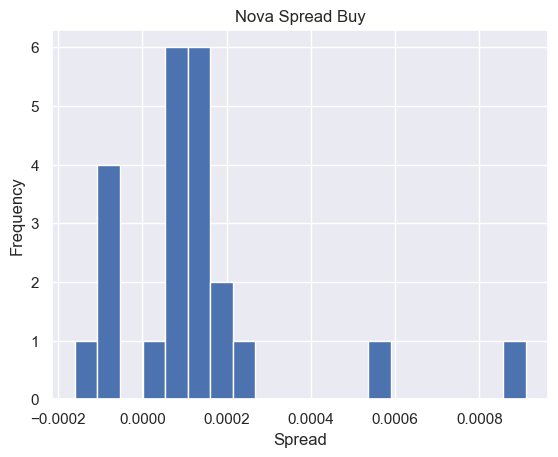

In [32]:
#create a histogram of the Nova sperad Buy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(nova_joined_sell['Close Spread'], bins=20)
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.title('Nova Spread Buy')
plt.show()

In [36]:
nova_joined.loc[:, ['Type', 'Price', 'Price.1', 'Profit', 'Open', 'Spread', 'Close', 'Close Spread', 'adjusted_open_price', 'adjusted_close_price', 'Nova_profit_calc']]

,Type,Price,Price.1,Profit,Open,Spread,Close,Close Spread,adjusted_open_price,adjusted_close_price,Nova_profit_calc
0,sell,1.09426,1.09367,177,1.0942,0.00006,1.0936,0.00007,1.09417,1.09368,147.0
1,buy,1.09367,1.09412,135,1.0936,0.00007,1.0941,0.00002,1.09367,1.09400,99.0
2,sell,1.09416,1.09428,-36,1.0941,0.00006,1.0942,0.00008,1.09407,1.09428,-63.0
3,buy,1.09425,1.09401,-72,1.0942,0.00005,1.0940,0.00001,1.09427,1.09390,-111.0
4,sell,1.09398,1.09368,90,1.0940,-0.00002,1.0936,0.00008,1.09397,1.09368,87.0
5,buy,1.09364,1.09342,-66,1.0936,0.00004,1.0935,-0.00008,1.09367,1.09340,-81.0
6,sell,1.09336,1.09361,-75,1.0935,-0.00014,1.0927,0.00091,1.09347,1.09278,207.0
7,buy,1.09282,1.09254,-84,1.0927,0.00012,1.0927,-0.00016,1.09277,1.09260,-51.0
8,sell,1.09269,1.09283,-42,1.0927,-0.00001,1.0927,0.00013,1.09267,1.09278,-33.0
9,buy,1.09286,1.09256,-90,1.0927,0.00016,1.0924,0.00016,1.09277,1.09230,-141.0


In [42]:
# find the total sum of nova_joined['Nova_profit_calc'] and nova_joined['Profit']
print(f"""Nova Profit: {nova_joined['Profit'].sum()} 
       Nova Profit Calc: {nova_joined['Nova_profit_calc'].sum()}""")

Nova Profit: -1608 
       Nova Profit Calc: -1573.4347826082294


In [19]:
# import in the simulation dataframe 
simulation = pd.read_csv('profit_df_new_index_select_day_3_11_24_3_12_24.csv')
# convert entry and exit_time to datetime
simulation['entry_time'] = pd.to_datetime(simulation['entry_time'], format='%Y-%m-%d %H:%M:%S.%f')
simulation['exit_time'] = pd.to_datetime(simulation['exit_time'], format='%Y-%m-%d %H:%M:%S.%f')
# filter to everything after 2024-03-11 12:08:00
simulation_filtered = simulation[simulation['entry_time'] > '2024-03-11 12:08:00']
simulation_filtered

,entry_time,entry_price,exit_time,exit_price,direction,brick_color,Nova_profit_initial,MSolutions_profit_initial,swap,swap_rate,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week
31,2024-03-11 12:08:31.644,1.0944,2024-03-11 13:05:39.412,1.0935,sell,green,217.434783,199.857143,0,0.000000,208.434783,184.857143,Monday,Monday
32,2024-03-11 13:06:58.256,1.0936,2024-03-11 14:00:50.796,1.0940,buy,green,57.071146,53.292208,0,0.000000,48.071146,38.292208,Monday,Monday
33,2024-03-11 14:04:35.588,1.0942,2024-03-11 14:30:59.050,1.0941,sell,green,-22.565217,-40.142857,0,0.000000,-31.565217,-55.142857,Monday,Monday
34,2024-03-11 14:32:43.219,1.0942,2024-03-11 15:10:31.513,1.0941,buy,green,-92.928854,-96.707792,0,0.000000,-101.928854,-111.707792,Monday,Monday
35,2024-03-11 15:17:11.272,1.0940,2024-03-11 15:49:27.916,1.0938,sell,red,7.434783,-10.142857,0,0.000000,-1.565217,-25.142857,Monday,Monday
36,2024-03-11 15:51:12.653,1.0936,2024-03-11 15:51:12.653,1.0936,buy,red,-62.928854,-66.707792,0,0.000000,-71.928854,-81.707792,Monday,Monday
37,2024-03-11 15:52:00.304,1.0935,2024-03-11 16:29:51.995,1.0927,sell,red,187.434783,169.857143,0,0.000000,178.434783,154.857143,Monday,Monday
38,2024-03-11 16:32:12.135,1.0928,2024-03-11 16:44:37.494,1.0926,buy,green,-122.928854,-126.707792,0,0.000000,-131.928854,-141.707792,Monday,Monday
39,2024-03-11 16:47:52.200,1.0925,2024-03-11 17:10:32.659,1.0916,sell,red,217.434783,199.857143,1,7.529478,215.964261,192.386621,Monday,Monday
40,2024-03-11 17:14:14.071,1.0918,2024-03-11 17:37:54.019,1.0920,buy,green,-2.928854,-6.707792,0,0.000000,-11.928854,-21.707792,Monday,Monday
